In [ ]:
!pip install timm
!pip install adversarial-robustness-toolbox
!pip install fastai --upgrade

     |████████████████████████████████| 296kB 6.9MB/s 
     |████████████████████████████████| 962kB 8.9MB/s 
     |████████████████████████████████| 3.2MB 23.9MB/s 
     |████████████████████████████████| 6.8MB 24.8MB/s 
     |████████████████████████████████| 21.6MB 1.6MB/s 
     |████████████████████████████████| 235kB 48.7MB/s 
     |████████████████████████████████| 25.3MB 54.1MB/s 
     |████████████████████████████████| 747kB 48.4MB/s 
  Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 194kB 8.5MB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
     |███████████████████████████████

In [ ]:
import timm 
import torch

from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *
from fastai.distributed import *
from fastprogress import fastprogress
from torchvision.models import *
from fastai.vision.models.xresnet import *
from fastai.callback.mixup import *
from fastcore.script import *

import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import ToTensor
from skimage.transform import resize
import numpy as np

In [ ]:
m = timm.create_model('vit_large_patch16_224', pretrained=True)


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_large_p16_224-4ee7a4dc.pth" to /root/.cache/torch/hub/checkpoints/jx_vit_large_p16_224-4ee7a4dc.pth


In [ ]:
m.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(


In [ ]:
!git clone https://github.com/Faryab/vit-attack.git

fatal: destination path 'vit-attack' already exists and is not an empty directory.


In [ ]:
# Load Imagenet Classses
!wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

import json
idx2label = []
cls2label = {}
with open("imagenet_class_index.json", "r") as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}


def get_top5(probabilities):
    res, ind = torch.topk(probabilities, 5)
    labels = [idx2label[x] for x in torch.flatten(ind)]
    lab_pos = [i for i, _ in enumerate(labels)]

    plt.bar(lab_pos, torch.flatten(res).detach().numpy(), color='green')
    plt.xlabel("Labels")
    plt.ylabel("Probabilities")
    plt.xticks(lab_pos, labels)

    plt.show()

--2021-03-28 16:23:24--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.162.0
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.162.0|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘imagenet_class_index.json.1’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.06s   

2021-03-28 16:23:25 (562 KB/s) - ‘imagenet_class_index.json.1’ saved [35363/35363]



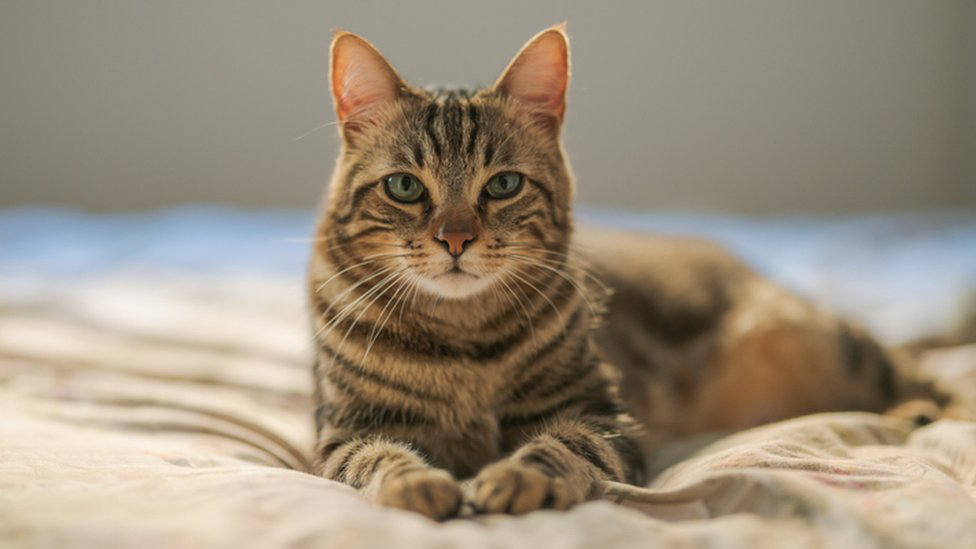

In [ ]:
cat_image = Image.open('vit-attack/cat.jpg')
cat_image


In [ ]:
# Rescale image to 224x224
resized_cat = resize(np.array(cat_image), (224, 224))

# unsqueeze to add artificial first dimension
tensor_cat = ToTensor()(resized_cat).unsqueeze(0) 

m.double()
cat_probs = m(tensor_cat.double())

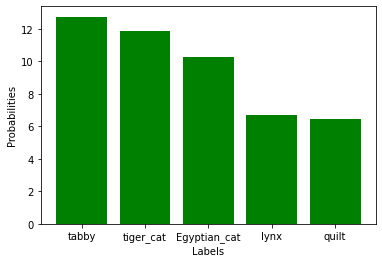

In [ ]:
get_top5(cat_probs)

In [ ]:
print(f"Cat prediction: {idx2label[np.argmax(cat_probs.detach().numpy())]}")

Cat prediction: tabby


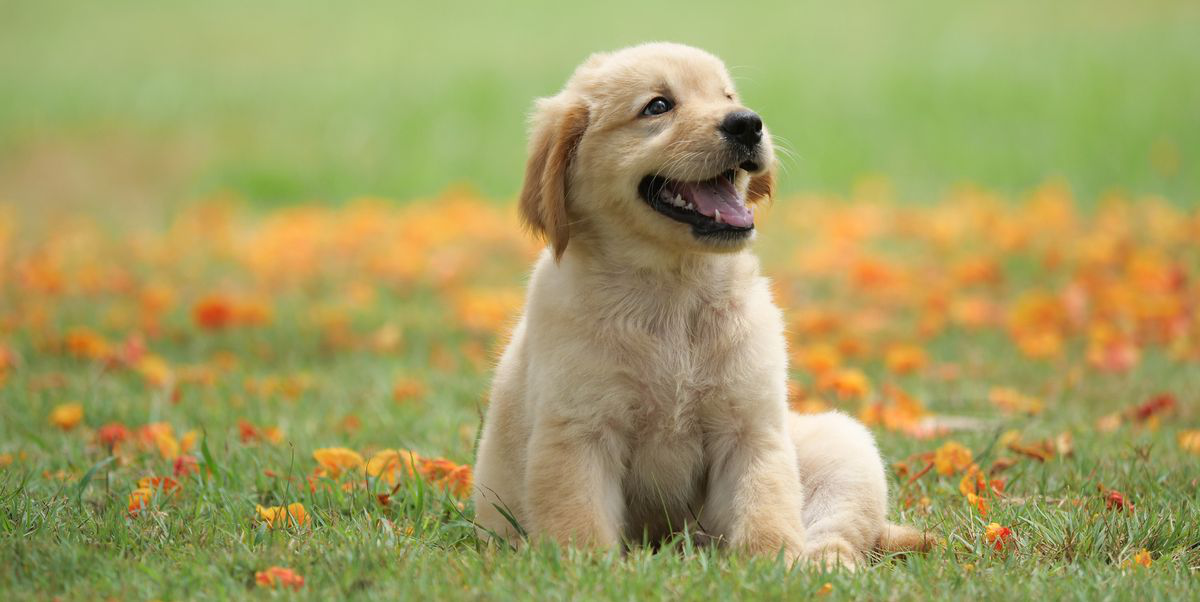

In [ ]:
dog_image = Image.open('vit-attack/dog.jpg')
dog_image

In [ ]:
# Rescale image to 224x224
resized_dog = resize(np.array(dog_image), (224, 224))

# unsqueeze to add artificial first dimension
tensor_dog = ToTensor()(resized_dog).unsqueeze(0) 

m.double()
dog_probs = m(tensor_dog.double())

In [ ]:
print(f"Dog prediction: {idx2label[np.argmax(dog_probs.detach().numpy())]}")

Dog prediction: Afghan_hound


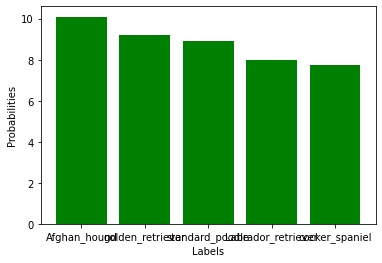

In [ ]:
get_top5(dog_probs)

## Black Box Attack


### Attempt at getting Fast AI working


In [ ]:
# Step 1: Load the Imagenette dataset
path = untar_data(URLs.IMAGENETTE)
path.ls()


(#3) [Path('/root/.fastai/data/imagenette2/noisy_imagenette.csv'),Path('/root/.fastai/data/imagenette2/train'),Path('/root/.fastai/data/imagenette2/val')]

In [ ]:
files = get_image_files(path/"val")

In [ ]:
# based off https://github.com/fastai/fastai/blob/master/nbs/examples/train_imagenette.py
def get_dls(size, woof, pct_noise, bs, sh=0., workers=None):
    assert pct_noise in [0,5,50], '`pct_noise` must be 0,5 or 50.'
    if size<=224: path = URLs.IMAGEWOOF_320 if woof else URLs.IMAGENETTE_320
    else        : path = URLs.IMAGEWOOF     if woof else URLs.IMAGENETTE
    source = untar_data(path)
    workers = ifnone(workers,min(8,num_cpus()))
    blocks=(ImageBlock, CategoryBlock)
    tfms = [RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)]
    batch_tfms = [Normalize.from_stats(*imagenet_stats)]
    if sh: batch_tfms.append(RandomErasing(p=0.3, max_count=3, sh=sh))
    
    csv_file = 'noisy_imagewoof.csv' if woof else 'noisy_imagenette.csv'
    inp = pd.read_csv(source/csv_file)
    dblock = DataBlock(blocks=blocks,
               splitter=ColSplitter(),
               get_x=ColReader('path', pref=source), 
               get_y=ColReader(f'noisy_labels_{pct_noise}'),
               item_tfms=tfms,
               batch_tfms=batch_tfms)
    
    return dblock.dataloaders(inp, path=source, bs=bs, num_workers=workers)

In [ ]:
data_loaders = get_dls(224, woof=False, pct_noise=0, bs=16)


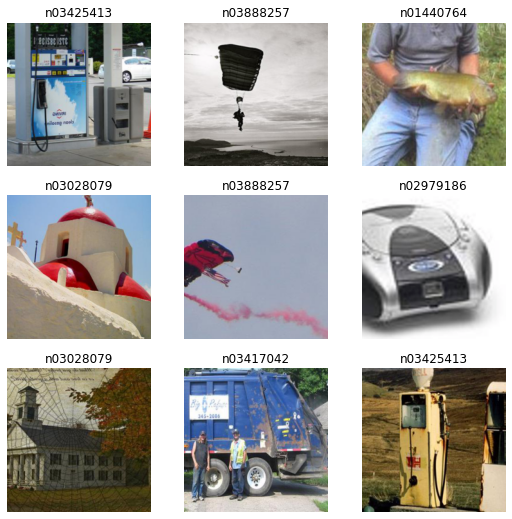

In [ ]:
data_loaders.show_batch()

### Back to ART...

In [ ]:
from art.utils import *
import torch.nn.functional as nnf

# (x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_stl()
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_cifar10()

In [ ]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)


In [ ]:
# Step 1a: Swap axes to PyTorch's NCHW format
x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)

# Resize to image_net size 224x224 
x_train = nnf.interpolate(torch.tensor(x_train), size=(224, 224), mode='bilinear', align_corners=False)
x_test = nnf.interpolate(torch.tensor(x_test), size=(224, 224), mode='bilinear', align_corners=False)

In [ ]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

In [ ]:
# Create the ART classifier
criterion = nn.CrossEntropyLoss()

classifier = PyTorchClassifier(
    model=m,
    loss=criterion,
    input_shape=(1, 224, 224),
    nb_classes=1000,
)

In [ ]:
# Step 5: Evaluate the ART classifier on benign test examples

predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

In [ ]:
# Step 6: Generate adversarial test examples
attack = FastGradientMethod(estimator=classifier, eps=0.2)
x_test_adv = attack.generate(x=x_test)

# Step 7: Evaluate the ART classifier on adversarial test examples

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))